**Christine Sako, DATASCI W210, SPRING 2026**

# Data Preprocessing and Exploratory Data Analysis on the Free Music Archive (FMA)

According to the FMA Github: https://github.com/mdeff/fma

All metadata and features for all tracks are distributed in fma_metadata.zip (342 MiB). The below tables can be used with pandas or any other data analysis tool. See the paper or the usage.ipynb notebook for a description.

- tracks.csv: per track metadata such as ID, title, artist, genres, tags and play counts, for all 106,574 tracks.
- genres.csv: all 163 genres with name and parent (used to infer the genre hierarchy and top-level genres).
- features.csv: common features extracted with librosa.
- echonest.csv: audio features provided by Echonest (now Spotify) for a subset of 13,129 tracks.

Then, you got various sizes of MP3-encoded audio data:

- fma_small.zip: 8,000 tracks of 30s, 8 balanced genres (GTZAN-like) (7.2 GiB)
- fma_medium.zip: 25,000 tracks of 30s, 16 unbalanced genres (22 GiB)
- fma_large.zip: 106,574 tracks of 30s, 161 unbalanced genres (93 GiB)
- fma_full.zip: 106,574 untrimmed tracks, 161 unbalanced genres (879 GiB)

## Loading Data and Confirming Shapes and Dtypes
Key Takeaways:
- The CSVs contain a nested hierarchy of column names that we have to unnest in order to get them a single-header format by using the `utils` package from the FMA github (https://github.com/mdeff/fma.git)
- The `echonest` dataset has the limiting track-level number of rows (13,129)

In [1]:
# Cloning FMA repo to get the utils file and importing packages
!git clone https://github.com/mdeff/fma.git
import sys
sys.path.append('/content/fma')
from utils import load
from IPython.display import display
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')


# Defining GDrive filepath
local_dir = '/content/drive/MyDrive/SPRING 2026/DATASCI 210/Capstone/Data/FMA'


# Loading CSVs to maintain metadata hierarchy
echonest = load(local_dir + '/echonest.csv')
features = load(local_dir + '/features.csv')
genres = load(local_dir + '/genres.csv')
tracks = load(local_dir + '/tracks.csv')


# Testing for valid indices
pd.testing.assert_index_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()


# Printing the shape and dtype heads of each dataset
print("\n")
print(f"`features` shape: {features.shape}")
display(features.dtypes.head())

print("\n")
print("\n")
print(f"`genres` shape: {genres.shape}")
display(genres.dtypes.head())

print("\n")
print("\n")
print(f"`echonest` shape: {echonest.shape}")
display(echonest.dtypes.head())

print("\n")
print("\n")
print(f"`tracks` shape: {tracks.shape}")
display(tracks.dtypes.head())



Cloning into 'fma'...
remote: Enumerating objects: 823, done.
remote: Counting objects: 100% (822/822), done.
remote: Compressing objects: 100% (287/287), done.
remote: Total 823 (delta 532), reused 621 (delta 527), pack-reused 1 (from 1)
Receiving objects: 100% (823/823), 4.08 MiB | 11.63 MiB/s, done.
Resolving deltas: 100% (532/532), done.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


`features` shape: (106574, 518)


feature      statistics  number
chroma_cens  kurtosis    01        float64
                         02        float64
                         03        float64
                         04        float64
                         05        float64
dtype: object





`genres` shape: (163, 4)


,0
#tracks,int64
parent,int64
title,object
top_level,int64






`echonest` shape: (13129, 249)


echonest  audio_features  acousticness        float64
                          danceability        float64
                          energy              float64
                          instrumentalness    float64
                          liveness            float64
dtype: object





`tracks` shape: (106574, 52)


album  comments                  int64
       date_created     datetime64[ns]
       date_released    datetime64[ns]
       engineer                 object
       favorites                 int64
dtype: object

## Subsetting To Tracks and Features with Echonest Data, Aligning Datasets, Flattening Multi-index Rows, and Concatenating Into a Single DataFrame
Key Takeaways:
- We have to create a common index based on the presence of `echonest` tracks to be able to filter down to a subset of these tracks for the `features` and `tracks` datasets
- Some datasets use MultiIndexing, which must be flattened in order to maintain proper mapping
- We combine all track-level data into a single dataframe for ease, and map primary and multi genre IDs to concatenate genre-level data.

In [2]:
# Creating a common index, keeping only tracks that have corresponding echonest features
common_index = tracks.index.intersection(echonest.index)

# Aligning tracks and features to the subset
echonest_aligned = echonest.loc[common_index]
features_aligned = features.loc[common_index]
tracks_aligned = tracks.loc[common_index]


# Printing subsetted and aligned shapes
print("\nDataset shapes:")
print(f"echonest_aligned shape: {echonest_aligned.shape}")
print(f"features_aligned shape: {features_aligned.shape}")
print(f"genres shape: {genres.shape}")
print(f"tracks_aligned shape: {tracks_aligned.shape}")

# Checking for multi-indexed columns
print("\nMultiIndex checks:")
print("Is echonest MultiIndex?", isinstance(echonest.columns, pd.MultiIndex))
print("Is features MultiIndex?", isinstance(features.columns, pd.MultiIndex))
print("Is genres MultiIndex?", isinstance(genres.columns, pd.MultiIndex))
print("Is tracks MultiIndex?", isinstance(tracks.columns, pd.MultiIndex))

# Flattening multi-indexed columns
echonest_flat = echonest_aligned.copy()
echonest_flat.columns = ['_'.join(col).strip() for col in echonest_flat.columns.values]

features_flat = features_aligned.copy()
features_flat.columns = ['_'.join(col).strip() for col in features_flat.columns.values]

tracks_flat = tracks_aligned.copy()
tracks_flat.columns = ['_'.join(col).strip() for col in tracks_flat.columns.values]

# Combining track-level data into a single DataFrame
eda_df = pd.concat([tracks_flat, features_flat, echonest_flat], axis = 1)

# Creating a mapping from genre ID to genre title
genre_map = genres['title'].to_dict()

# Converting `track_genres` to readable names
eda_df['track_genres_name'] = eda_df['track_genres'].apply(
    lambda x: genre_map.get(int(x[0])) if isinstance(x, list) and x else None
)

# Converting `track_genres_all)` to readable names
eda_df['track_genres_all_names'] = eda_df['track_genres_all'].apply(
    lambda ids: [genre_map.get(int(i)) for i in ids] if isinstance(ids, list) else []
)

print(f"\nCombined EDA DataFrame shape: {eda_df.shape}")
display(eda_df.head())




Dataset shapes:
echonest_aligned shape: (13129, 249)
features_aligned shape: (13129, 518)
genres shape: (163, 4)
tracks_aligned shape: (13129, 52)

MultiIndex checks:
Is echonest MultiIndex? True
Is features MultiIndex? True
Is genres MultiIndex? False
Is tracks MultiIndex? True

Combined EDA DataFrame shape: (13129, 821)


,album_comments,album_date_created,album_date_released,album_engineer,album_favorites,album_id,album_information,album_listens,album_producer,album_tags,...,echonest_temporal_features_216,echonest_temporal_features_217,echonest_temporal_features_218,echonest_temporal_features_219,echonest_temporal_features_220,echonest_temporal_features_221,echonest_temporal_features_222,echonest_temporal_features_223,track_genres_name,track_genres_all_names
track_id,,,,,,,,,,,,,,,,,,,,,
2,0,2008-11-26 01:44:45,2009-01-05,NaN,4,1,<p></p>,6073,NaN,[],...,0.233070,0.192880,0.027455,0.06408,3.67696,3.61288,13.316690,262.929749,Hip-Hop,[Hip-Hop]
3,0,2008-11-26 01:44:45,2009-01-05,NaN,4,1,<p></p>,6073,NaN,[],...,0.258464,0.220905,0.081368,0.06413,6.08277,6.01864,16.673548,325.581085,Hip-Hop,[Hip-Hop]
5,0,2008-11-26 01:44:45,2009-01-05,NaN,4,1,<p></p>,6073,NaN,[],...,0.256821,0.237820,0.060122,0.06014,5.92649,5.86635,16.013849,356.755737,Hip-Hop,[Hip-Hop]
10,0,2008-11-26 01:45:08,2008-02-06,NaN,4,6,NaN,47632,NaN,[],...,0.283352,0.267070,0.125704,0.08082,8.41401,8.33319,21.317064,483.403809,Pop,[Pop]
134,0,2008-11-26 01:44:45,2009-01-05,NaN,4,1,<p></p>,6073,NaN,[],...,0.234686,0.199550,0.149332,0.06440,11.26707,11.20267,26.454180,751.147705,Hip-Hop,[Hip-Hop]


## Checking Missing Values, Unique Tracks, Data Types, and Category Types
Key Takeaways:
- 11 columns have >80% missing values
- There are 13,129 unique track IDs

In [3]:
# Checking missing values
# Calculating percentage of missing values per column
missing_pct = eda_df.isnull().mean()

# Filtering columns with >80% missing
high_missing = missing_pct[missing_pct > .80].sort_values(ascending = False)

# Printing results
print("Columns with > 80% missing values:")
display(high_missing.apply(lambda x: f"{x:.2f}"))

# Calculating the percentage of missing values per row
missing_per_row = eda_df.isnull().mean(axis = 1) * 100
print("\n")
print(f"\nAverage missing values per track: {missing_per_row.mean():.2f}%")


# Retreiving and printing number of unique track IDs
print(f"\nNumber of unique track IDs: {eda_df.index.nunique()}")


# Retreiving and printing data types counts
dtype_summary = eda_df.dtypes.apply(lambda x: x.name).value_counts()
print("\n")
print("\nData type counts:")
display(dtype_summary)


# Counting and printing category types
numeric_cols = eda_df.select_dtypes(include = ['float64', 'int64']).columns
categorical_cols = eda_df.select_dtypes(include = ['object', 'category']).columns
datetime_cols = eda_df.select_dtypes(include = ['datetime64']).columns

print("\n")
print("\nCategory type counts:")
print(f"Numeric columns: {len(numeric_cols)}")
print(f"Categorical columns: {len(categorical_cols)}")
print(f"Datetime columns: {len(datetime_cols)}")


Columns with > 80% missing values:


,0
track_lyricist,0.99
track_publisher,0.99
artist_active_year_end,0.96
track_composer,0.96
track_information,0.94
artist_wikipedia_page,0.91
artist_related_projects,0.87
echonest_ranks_song_currency_rank,0.85
echonest_ranks_song_hotttnesss_rank,0.83
artist_associated_labels,0.83





Average missing values per track: 2.48%

Number of unique track IDs: 13129



Data type counts:


,count
float64,764
object,29
int64,15
datetime64[ns],7
category,6





Category type counts:
Numeric columns: 779
Categorical columns: 35
Datetime columns: 7


## Categorical Data Distributions

### Genre Counts and Number of Genres Distribution
Key Takeaways:
- Electronic, Rock, and Pop are the most popular genres
- Single-genre tracks comprise ~40% of tracks


Top 10 primary genres:


,count
track_genres_name,
Electronic,2805
Rock,2169
Pop,1399
Folk,950
Hip-Hop,937
Punk,784
Jazz,547
Indie-Rock,494
Old-Time / Historic,412


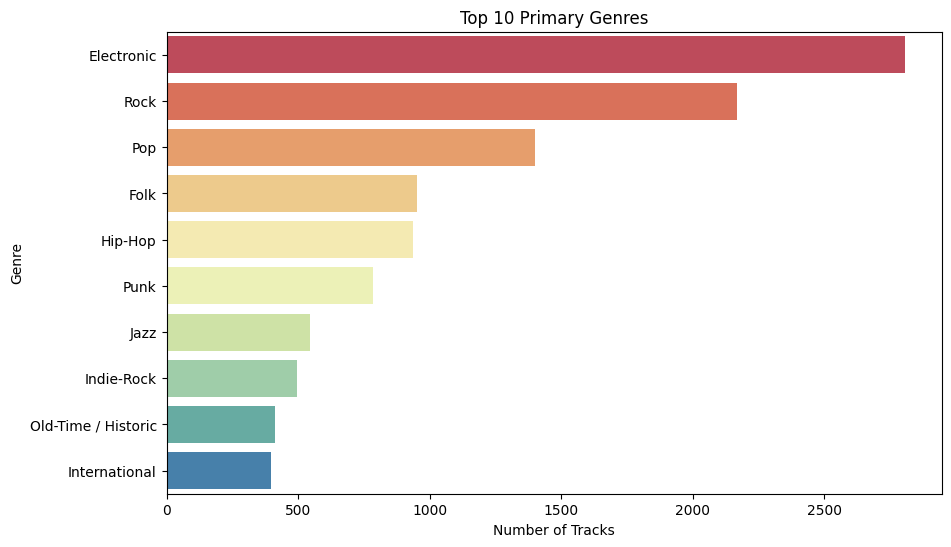






Tracks by number of genres (count + percentage):


,count,percentage
num_genres,,
1,5067,0.39
2,3034,0.23
3,2987,0.23
4,1237,0.09
5,503,0.04
6,186,0.01
7,89,0.01
8,21,0.00
9,5,0.00


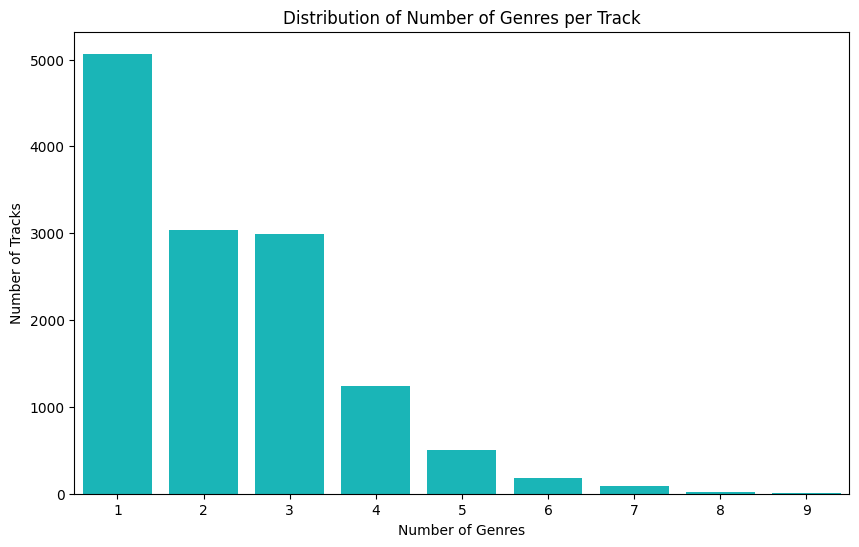

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Distribution of primary genres
print("\nTop 10 primary genres:")
top_genres = eda_df['track_genres_name'].value_counts().head(10)
display(top_genres)


# Plotting top 10 genres
plt.figure(figsize = (10,6))
sns.barplot(x = top_genres.values, y = top_genres.index, hue = top_genres.index, palette = 'Spectral')
plt.title("Top 10 Primary Genres")
plt.xlabel("Number of Tracks")
plt.ylabel("Genre")
plt.show()


# Number of genres per track
eda_df['num_genres'] = eda_df['track_genres_all_names'].apply(len)

# Getting counts and percentages
genre_count = eda_df['num_genres'].value_counts().sort_index()
genre_pct = eda_df['num_genres'].value_counts(normalize = True).sort_index()

# Combining into a data frame
genre_summary = pd.DataFrame({
    'count': genre_count,
    'percentage': genre_pct.round(2)
})

print("\n")
print("\n")
print("\nTracks by number of genres (count + percentage):")
display(genre_summary)
print("\n")

# Ploting number of genres distribution
plt.figure(figsize = (10,6))
sns.barplot(x = genre_summary.index, y = genre_summary['count'], color = 'darkturquoise')
plt.title("Distribution of Number of Genres per Track")
plt.xlabel("Number of Genres")
plt.ylabel("Number of Tracks")
plt.show()

### Track Listens and Favorites Distribution
Key Takeaways:
- Both `track_listens` and `track_favorites` are both heavily right-skewed and heavy tailed.
- Favorites appear even more concentrated than listens. Tracks are rarely favorited, while a tiny subset attracts intense engagement.

Track listens summary statistics:


,track_listens
count,13129.000000
mean,2147.068703
std,9434.471644
min,12.000000
50%,694.000000
90%,3993.400000
99%,22803.800000
max,543252.000000





Track favorites summary statistics:


,track_favorites
count,13129.000000
mean,4.310305
std,20.884705
min,0.000000
50%,1.000000
90%,8.000000
99%,44.000000
max,1482.000000





Correlation between popularity measures:


,track_listens,track_favorites
track_listens,1.000000,0.835644
track_favorites,0.835644,1.000000


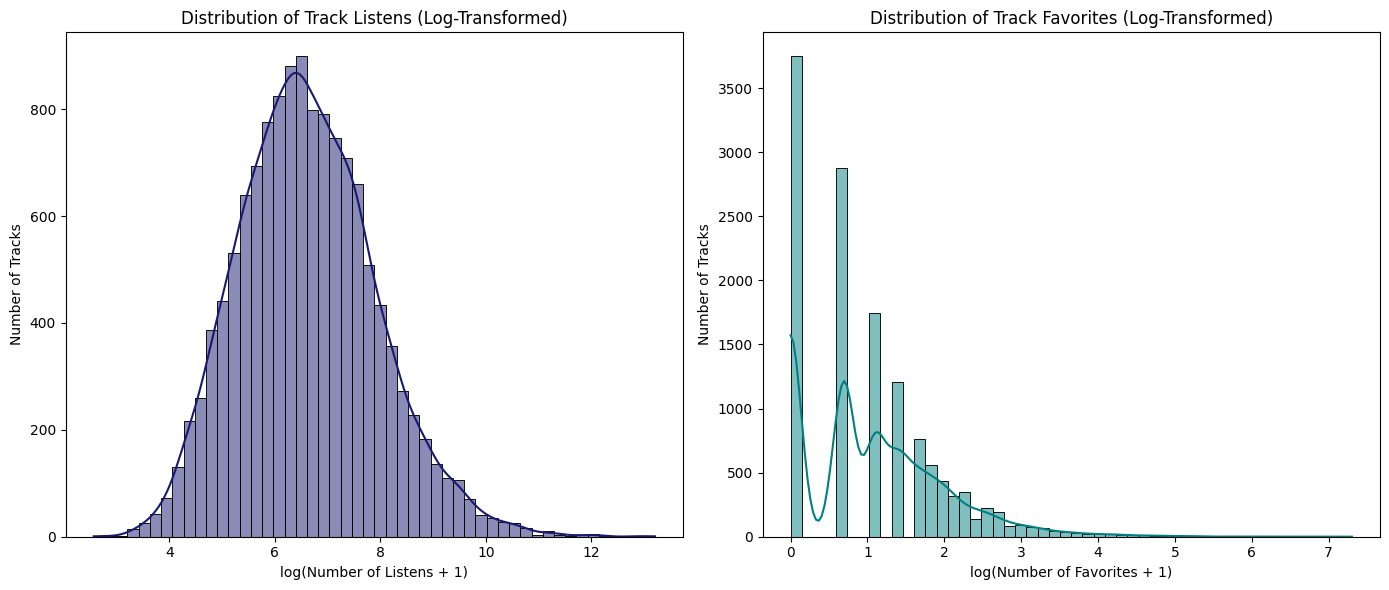

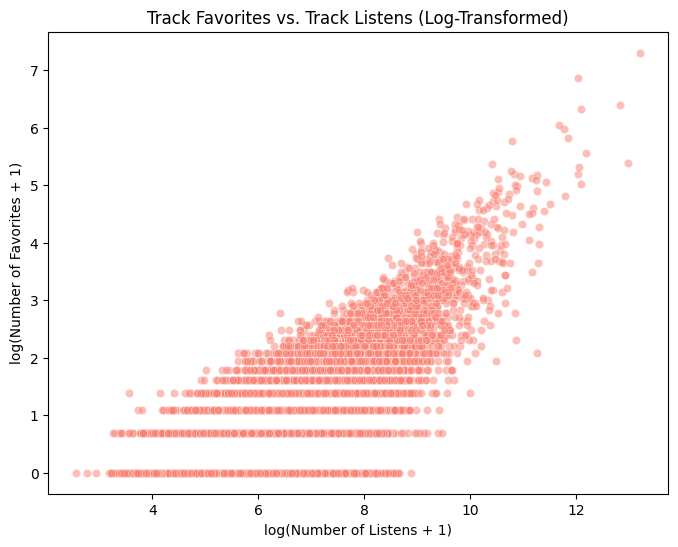

In [5]:
# Creating summary statistics for `track_listens`
listen_summary = eda_df['track_listens'].describe(
    percentiles=[0.5, 0.9, 0.99]
)
print("Track listens summary statistics:")
display(listen_summary)
print("\n")

# Creating summary statistics for `track_favorites`
favorite_summary = eda_df['track_favorites'].describe(
    percentiles=[0.5, 0.9, 0.99]
)
print("\nTrack favorites summary statistics:")
display(favorite_summary)
print("\n")

# Showing correlation between `track_listens` and `track_favorites`
popularity_corr = eda_df[['track_listens', 'track_favorites']].corr()
print("\nCorrelation between popularity measures:")
display(popularity_corr)
print("\n")
print("\n")

# Setting up plotting
plt.figure(figsize = (14,6))

# Using log1p-transform to reduce skew and handle zeros
eda_df['log_track_listens'] = np.log1p(eda_df['track_listens'])
eda_df['log_track_favorites'] = np.log1p(eda_df['track_favorites'])

# Plotting histogram for `log_track_listens`
plt.subplot(1, 2, 1)
sns.histplot(eda_df['log_track_listens'], bins = 50, color = 'midnightblue', kde = True)
plt.title('Distribution of Track Listens (Log-Transformed)')
plt.xlabel('log(Number of Listens + 1)')
plt.ylabel('Number of Tracks')

# Plotting histogram for `log_track_favorites`
plt.subplot(1, 2, 2)
sns.histplot(eda_df['log_track_favorites'], bins = 50, color = 'teal', kde = True)
plt.title('Distribution of Track Favorites (Log-Transformed)')
plt.xlabel('log(Number of Favorites + 1)')
plt.ylabel('Number of Tracks')

plt.tight_layout()
plt.show()

# Plotting scatter plot to see their relationship
plt.figure(figsize = (8,6))
sns.scatterplot(
    x='log_track_listens',
    y='log_track_favorites',
    data=eda_df,
    alpha=0.5,
    color='salmon'
)
plt.title('Track Favorites vs. Track Listens (Log-Transformed)')
plt.xlabel('log(Number of Listens + 1)')
plt.ylabel('log(Number of Favorites + 1)')
plt.show()

## Numeric Data Distributions

### Audio Features Distributions
Key Takeaways:
- **Acousticness** distribution is bi-modal that is heavily leaning toward high acousticness. Likely a strong differentiator for ad mood matching.
- **Danceability** has a very wide, centered distribution. Could be good for pacing and movement cues in ads.
- **Energy** has a broad spread that is slightly high skewed. Good for attention grabbing vs. ambience in ads, with high energy as a likely indicator for popularity and ad recall.
- **Instrumentalness** median is very high, with many tracks being very instrumentally focused. Good for advertising where music vocals will not clash with ad voiceover, etc.
- **Liveness** median is very low, meaning mostly polishedm studio produced tracks.
- **Speechiness** is skewed very low, which suggests there is not a high presence of spoken/rapped lyrics. This helps focus attention to melodic elements that would match with ad tone.
- **Tempo** is concentrated around 120 BPM, which alignes with the known "sweet spot" for music tempo. Very commercially friendly.
- **Valence** covers a wide emotional range that would support a variety of moods. Good supplemental feature to genre to match ad tone.
- The individual distributions overall show that this dataset would work contextually well for ads (e.g. high instrumentalness, low speechiness) with effective creative levers (e.g. energy/attention, valence/emotion, acousticness/authenticity, tempo/pacing)


Audio features summary stats:



,count,mean,std,min,25%,50%,75%,90%,max
echonest_audio_features_acousticness,13129.0,0.525,0.384,0.000,0.104,0.574,0.921,0.989,0.996
echonest_audio_features_danceability,13129.0,0.487,0.190,0.051,0.345,0.486,0.629,0.746,0.969
echonest_audio_features_energy,13129.0,0.538,0.278,0.000,0.321,0.549,0.776,0.907,1.000
echonest_audio_features_instrumentalness,13129.0,0.641,0.361,0.000,0.323,0.838,0.918,0.951,0.998
echonest_audio_features_liveness,13129.0,0.188,0.158,0.025,0.101,0.119,0.211,0.375,0.980
echonest_audio_features_speechiness,13129.0,0.099,0.137,0.022,0.037,0.049,0.085,0.227,0.966
echonest_audio_features_tempo,13129.0,123.080,35.015,12.753,95.967,120.057,145.318,170.162,251.072
echonest_audio_features_valence,13129.0,0.440,0.276,0.000,0.197,0.418,0.666,0.842,1.000





Summary stats and histogram per audio feature:





,count,mean,std,min,25%,50%,75%,90%,max
echonest_audio_features_acousticness,13129.0,0.525,0.384,0.0,0.104,0.574,0.921,0.989,0.996


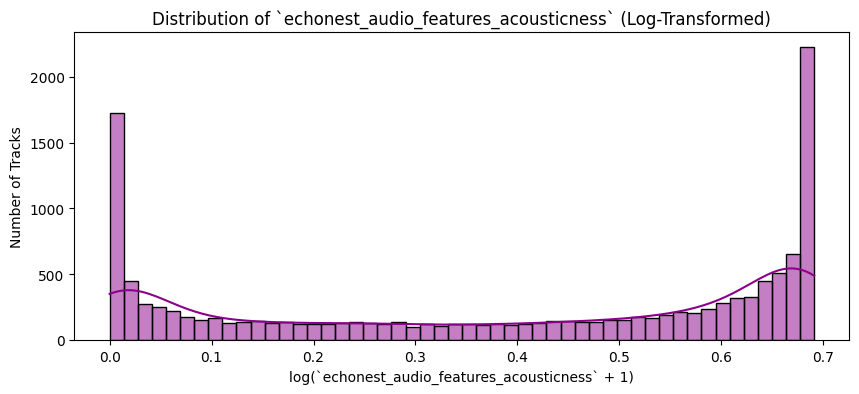

,count,mean,std,min,25%,50%,75%,90%,max
echonest_audio_features_danceability,13129.0,0.487,0.19,0.051,0.345,0.486,0.629,0.746,0.969


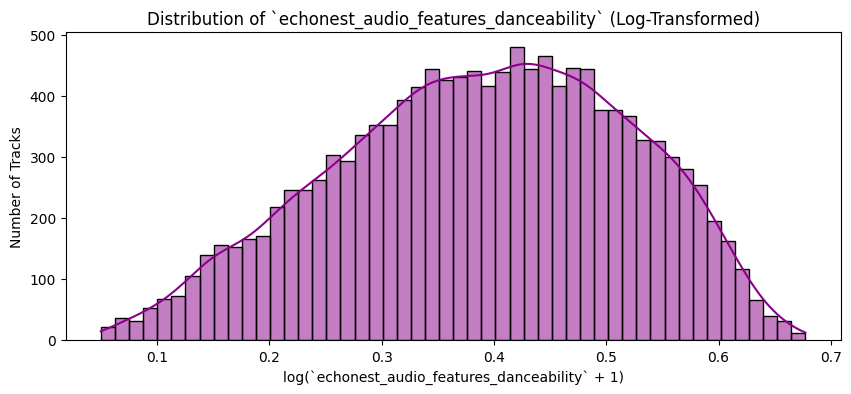

,count,mean,std,min,25%,50%,75%,90%,max
echonest_audio_features_energy,13129.0,0.538,0.278,0.0,0.321,0.549,0.776,0.907,1.0


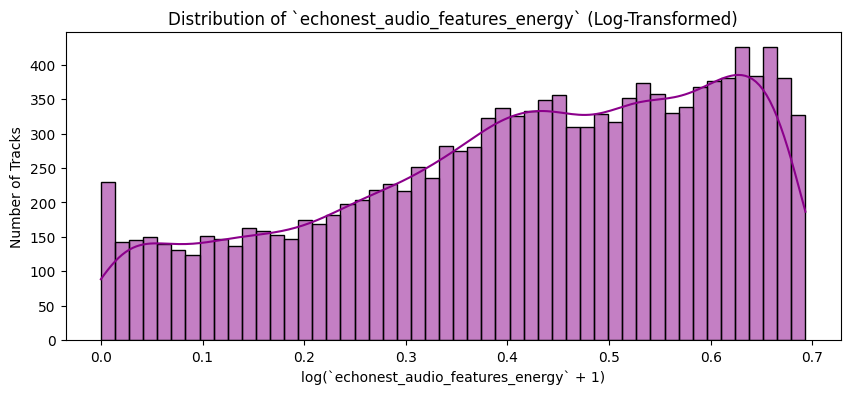

,count,mean,std,min,25%,50%,75%,90%,max
echonest_audio_features_instrumentalness,13129.0,0.641,0.361,0.0,0.323,0.838,0.918,0.951,0.998


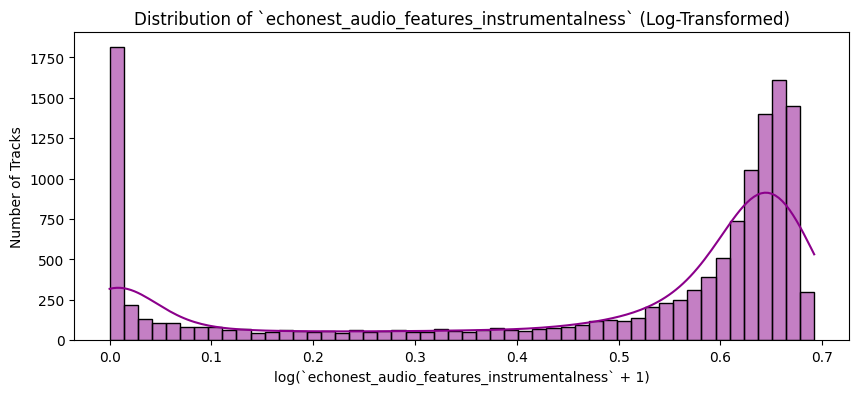

,count,mean,std,min,25%,50%,75%,90%,max
echonest_audio_features_liveness,13129.0,0.188,0.158,0.025,0.101,0.119,0.211,0.375,0.98


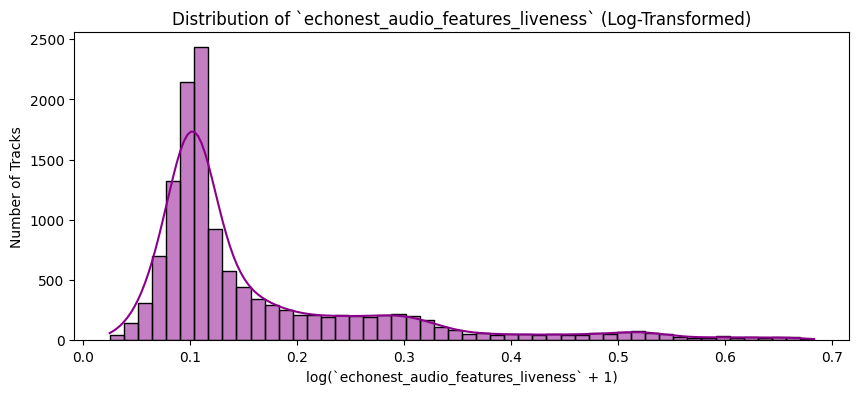

,count,mean,std,min,25%,50%,75%,90%,max
echonest_audio_features_speechiness,13129.0,0.099,0.137,0.022,0.037,0.049,0.085,0.227,0.966


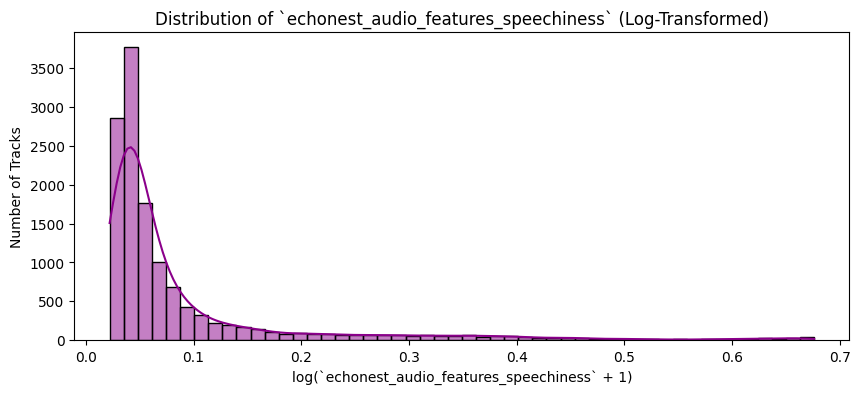

,count,mean,std,min,25%,50%,75%,90%,max
echonest_audio_features_tempo,13129.0,123.08,35.015,12.753,95.967,120.057,145.318,170.162,251.072


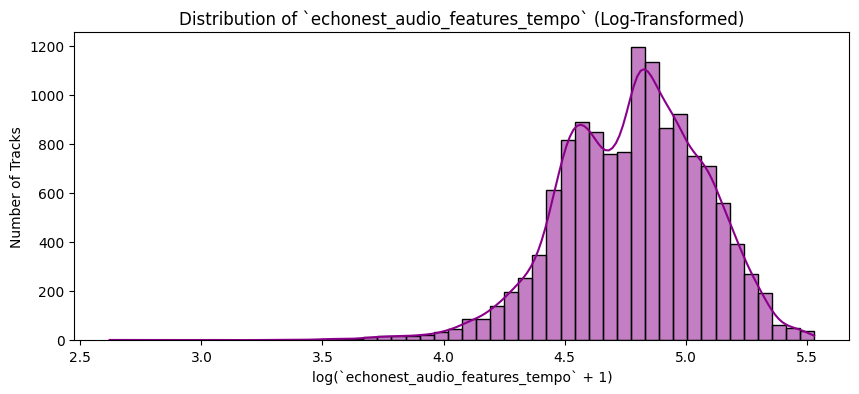

,count,mean,std,min,25%,50%,75%,90%,max
echonest_audio_features_valence,13129.0,0.44,0.276,0.0,0.197,0.418,0.666,0.842,1.0


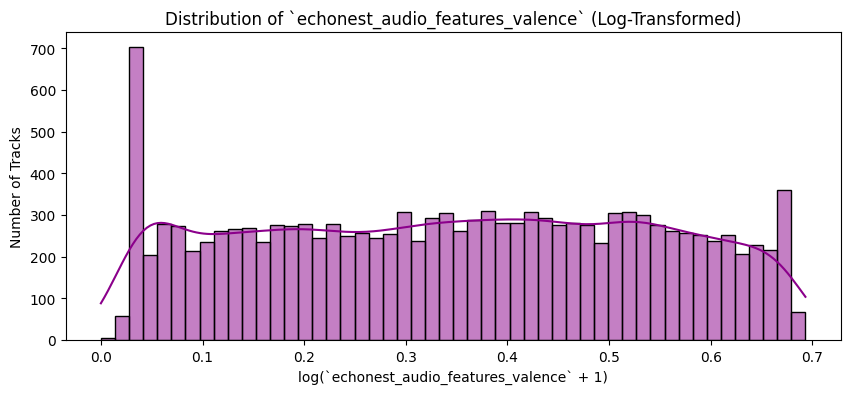

In [6]:
# Creating audio features set
eda_df.columns = [
    '_'.join(col).strip() if isinstance(col, tuple) else col
    for col in eda_df.columns
]

audio_cols = [
    'echonest_audio_features_acousticness',
    'echonest_audio_features_danceability',
    'echonest_audio_features_energy',
    'echonest_audio_features_instrumentalness',
    'echonest_audio_features_liveness',
    'echonest_audio_features_speechiness',
    'echonest_audio_features_tempo',
    'echonest_audio_features_valence'
]

# Creating summary stats for audio features
print("\nAudio features summary stats:\n")
audio_summary = eda_df[audio_cols].describe(percentiles=[0.25, 0.5, 0.75, 0.9]).T.round(3)
display(audio_summary)
print("\n")

# Plotting the table row and histogram for each audio feature
print("\nSummary stats and histogram per audio feature:\n")

# Using log1p transform skewed features
for feature in audio_cols:

    # Displaying summary row for the single feature
    print("\n")
    display(audio_summary.loc[[feature]])
    fig, ax = plt.subplots(figsize = (10,4))

    # Plotting histogram for the single feature

    sns.histplot(np.log1p(eda_df[feature]), bins = 50, kde = True, color = 'darkmagenta')
    ax.set_title(f'Distribution of `{feature}` (Log-Transformed)')
    ax.set_xlabel(f'log(`{feature}` + 1)')
    ax.set_ylabel('Number of Tracks')
    plt.show()


## Cross-feature Analysis

### Correlation Between Audio Features vs. Popularity
Key Takeaways:
- No single audio features is a strong indicator for popularity, which is good for the goal of ad matching vs. trying to optimize for popularity.

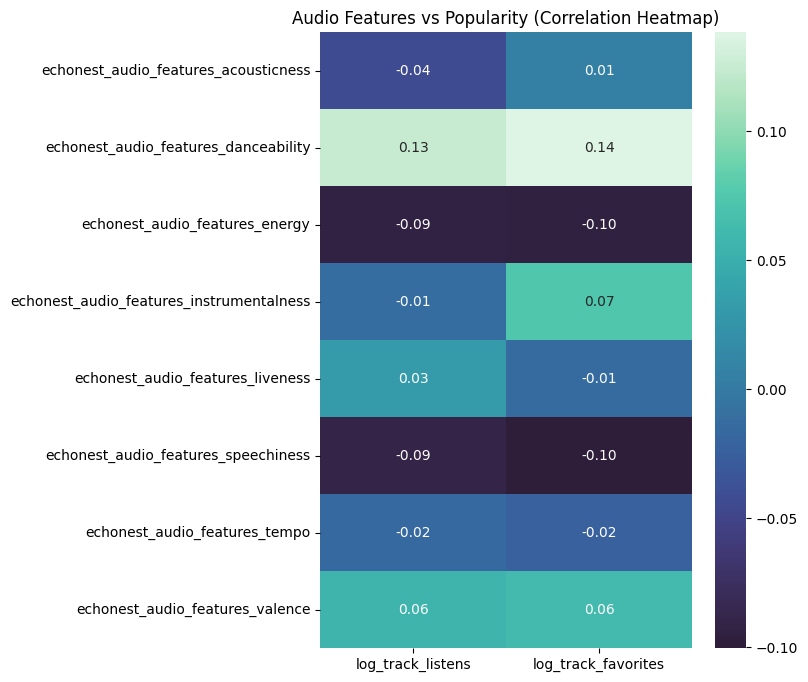

In [7]:
# Creating list of popularity columns from before
popularity_cols = ['log_track_listens', 'log_track_favorites']

# Computing correlation matrix of audio features vs. popularity
audio_pop_corr = eda_df[audio_cols + popularity_cols].corr()

# Subsetting audio features vs popularity
heatmap_data = audio_pop_corr.loc[audio_cols, popularity_cols]

# Plotting
plt.figure(figsize = (6,8))
sns.heatmap(
    heatmap_data,
    annot = True,
    fmt = ".2f",
    cmap = "mako",
    center = 0
)
plt.title("Audio Features vs Popularity (Correlation Heatmap)")
plt.show()


### Popularity Tiers and Sonic Profiles
Key Takeaways:
- **Acousticness** is non-linear which suggests both more and moderately acoustic tracks can be popular.
- **Danceability** increases with popularity, which could lend to viral appeal.
- **Energy** decreases at the highest popularity tier, which suggests the most popular have a more smooth, radio friendly vibe.
- **Instrumentalness** decreases slightly with popularity, meaning vocals might appeal more to mainstream appeal (but possibly not in an ad context).
- **Liveness** has a subtle increase with popularity.
- **Speechiness** deacreases with popularity, suggesting less spoken/rapped and more melodically focused tracks are more popular.
- **Tempo** decreases slightly with popularity, but mainly stays > 120 BPM.
- **Valence** increases with popularity, suggesting happier/brighter songs tend to be more catchy with their feel-good vibes.
- Danceable, high valence, and melodically vocal-forward tracks may resonate more overall, and smoother vs. high energy tracks may trend better. Acousticness seems to be palateable at many levels.

Audio Features by Popularity Tier:



,echonest_audio_features_acousticness,echonest_audio_features_danceability,echonest_audio_features_energy,echonest_audio_features_instrumentalness,echonest_audio_features_liveness,echonest_audio_features_speechiness,echonest_audio_features_tempo,echonest_audio_features_valence
popularity_bucket,,,,,,,,
Low,0.585,0.454,0.564,0.643,0.178,0.121,124.365,0.427
Mid-Low,0.507,0.477,0.548,0.655,0.184,0.097,123.753,0.423
Mid-High,0.461,0.505,0.548,0.638,0.193,0.093,122.892,0.444
High,0.546,0.513,0.489,0.627,0.196,0.086,121.304,0.465


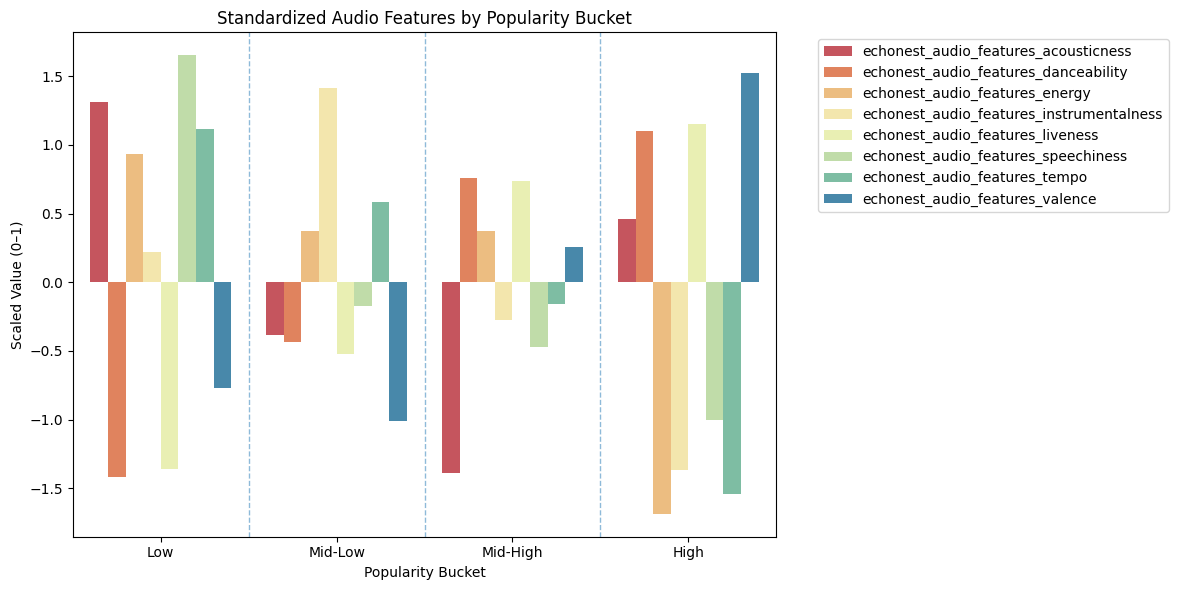

In [8]:
from sklearn.preprocessing import StandardScaler

# Creating popularity quartiles from `log_track_listens`
eda_df['popularity_bucket'] = pd.qcut(
    eda_df['log_track_listens'],
    q=4,
    labels=['Low', 'Mid-Low', 'Mid-High', 'High']
)

# Creating mean audio features by popularity tier
bucket_audio_means = (
    eda_df
    .groupby('popularity_bucket', observed = True)[audio_cols]
    .mean()
    .round(3)
)

# Showing popularity tiers vs. audio features
print("Audio Features by Popularity Tier:\n")
display(bucket_audio_means)

# Copying bucket means for standardization
bucket_scaled = bucket_audio_means.copy()

# Appyling scaling column-wise
scaler = StandardScaler()
bucket_scaled[audio_cols] = scaler.fit_transform(bucket_scaled[audio_cols])

# Resetting index for plotting
bucket_scaled_reset = bucket_scaled.reset_index()

# Melting for grouped bar plotting
melted = bucket_scaled_reset.melt(
    id_vars = 'popularity_bucket',
    value_vars = audio_cols,
    var_name = 'Audio Feature',
    value_name = 'Scaled Value'
)

# Plotting bar chart
print("\n")
plt.figure(figsize=(12,6))
sns.barplot(
    data=melted,
    x='popularity_bucket',
    y='Scaled Value',
    hue='Audio Feature',
    palette='Spectral'
)

# Adding vertical dotted lines between popularity buckets for readability
ax = plt.gca()
for x in [0.5, 1.5, 2.5]:
    ax.axvline(
        x = x,
        linestyle = '--',
        linewidth = 1,
        alpha = 0.5
    )

plt.title('Standardized Audio Features by Popularity Bucket')
plt.ylabel('Scaled Value (0–1)')
plt.xlabel('Popularity Bucket')
plt.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left')
plt.tight_layout()
plt.show()

### Check of Genres' Audio Features Assumptions
Key Takeaways:
- **Electronic**	is synthetic, rhythmic, and instrumental
- **Folk** is acoustic, low-energy, and has low danceability
- **Hip-Hop**	is rhythmic, speech-heavy, and emotionally high
- **Pop**	is balanced and middle-of-the-road across most features
- **Punk**	is high-energy, and has low danceability
- **Rock**	is high-energy and relatively moderate across most features
- ***Acousticness*** cleanly separates **Folk** and **Electronic**
- High ***danceability*** does not equate to high ***energy*** (e.g. **Punk** has low ***danceability*** but high ***energy***, **Hip-Hop** has high ***danceability*** without extreme ***energy***, and **Electronic** has a blend of both.
- ***Speechiness*** differentiates **Hip-hop** from other popular genres.
- The audio features per genre align with general expectations from each music type.

Audio features for the top 6 Genres:



,echonest_audio_features_acousticness,echonest_audio_features_danceability,echonest_audio_features_energy,echonest_audio_features_instrumentalness,echonest_audio_features_liveness,echonest_audio_features_speechiness,echonest_audio_features_tempo,echonest_audio_features_valence
track_genres_name,,,,,,,,
Electronic,0.344,0.584,0.603,0.744,0.174,0.124,124.749,0.427
Folk,0.789,0.440,0.309,0.594,0.166,0.065,115.849,0.363
Hip-Hop,0.411,0.623,0.565,0.359,0.189,0.251,118.598,0.591
Pop,0.486,0.528,0.559,0.499,0.165,0.065,124.147,0.481
Punk,0.476,0.357,0.761,0.646,0.202,0.075,132.958,0.430
Rock,0.507,0.419,0.631,0.647,0.184,0.075,127.636,0.449


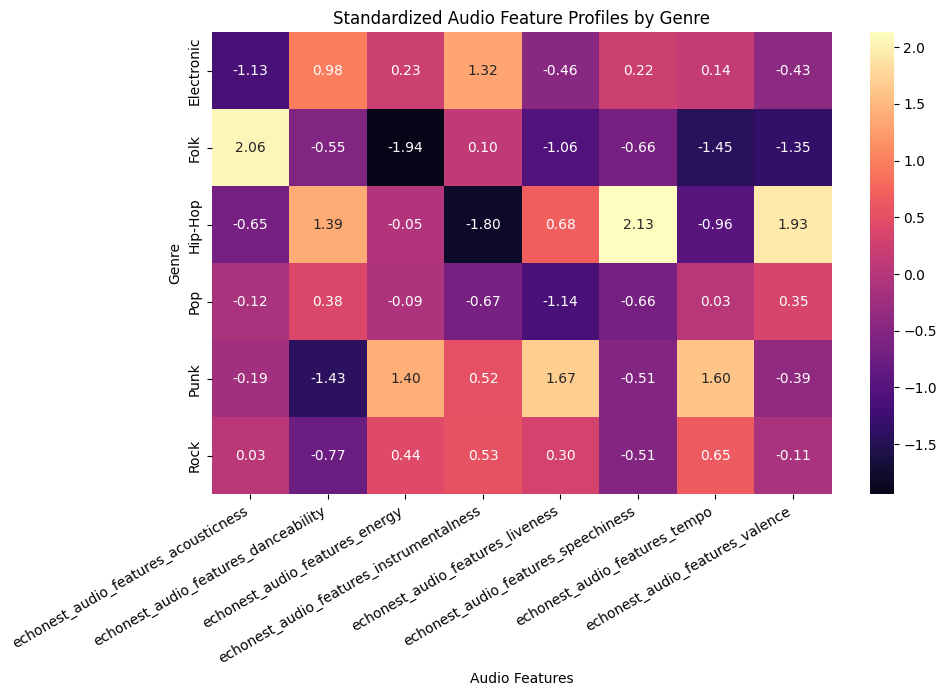

In [9]:
# Checking the top 6 genres's audio features
top_genres = eda_df['track_genres_name'].value_counts().head(6).index

genre_audio_means = (
    eda_df[eda_df['track_genres_name'].isin(top_genres)]
    .groupby('track_genres_name')[audio_cols]
    .mean()
    .round(3)
)

print("Audio features for the top 6 Genres:\n")
display(genre_audio_means)
print("\n")

# Standardizing audio features for comparability
scaled = pd.DataFrame(
    StandardScaler().fit_transform(genre_audio_means),
    index = genre_audio_means.index,
    columns = genre_audio_means.columns
)

plt.figure(figsize = (10, 6))
sns.heatmap(
    scaled,
    cmap = 'magma',
    center = 0,
    annot = True,
    fmt = ".2f"
)

plt.title("Standardized Audio Feature Profiles by Genre")
plt.xlabel("Audio Features")
plt.ylabel("Genre")
plt.xticks(rotation = 30, ha = 'right')
plt.show()



### Correlation Among Audio Features
Key Takeaways:
- **Acousticness** and **Energy** are highly inversely correlated, suggesting more acoutstic tracks tend to have lower energy
- **Danceability** and **Valence** are moderately positively correlated, suggesting more danceable tracks also tend to be happier/brighter
- **Speechiness** and **Instrumentalness** are slightly inversely correlated, suggesting more speech-heavy trakcs have less instrumentalness
- Most features are loosely correlated (especially **Energy** vs. **Instrumentalness**, **Liveness** vs. **Tempo**, **Acousticness** vs. **Valence**)

Correlation among audio features:


,echonest_audio_features_acousticness,echonest_audio_features_danceability,echonest_audio_features_energy,echonest_audio_features_instrumentalness,echonest_audio_features_liveness,echonest_audio_features_speechiness,echonest_audio_features_tempo,echonest_audio_features_valence
echonest_audio_features_acousticness,1.000,-0.190,-0.477,0.110,0.041,0.039,-0.111,-0.085
echonest_audio_features_danceability,-0.190,1.000,0.045,-0.118,-0.143,0.171,-0.094,0.429
echonest_audio_features_energy,-0.477,0.045,1.000,-0.002,0.046,-0.009,0.227,0.219
echonest_audio_features_instrumentalness,0.110,-0.118,-0.002,1.000,-0.059,-0.217,0.023,-0.145
echonest_audio_features_liveness,0.041,-0.143,0.046,-0.059,1.000,0.073,-0.008,-0.018
echonest_audio_features_speechiness,0.039,0.171,-0.009,-0.217,0.073,1.000,0.032,0.095
echonest_audio_features_tempo,-0.111,-0.094,0.227,0.023,-0.008,0.032,1.000,0.130
echonest_audio_features_valence,-0.085,0.429,0.219,-0.145,-0.018,0.095,0.130,1.000


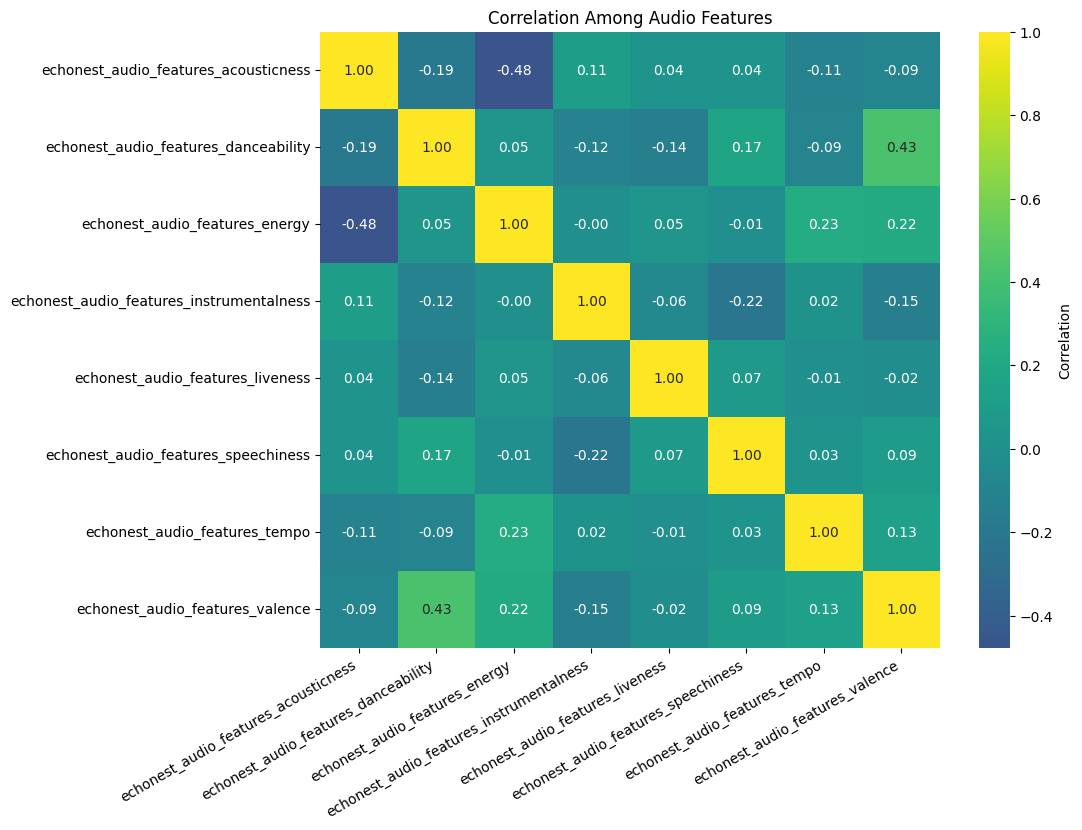

In [10]:
# Creating correlation among audio features
audio_corr = eda_df[audio_cols].corr()
print("Correlation among audio features:")
display(audio_corr.round(3))
print("\n")

plt.figure(figsize = (10,8))
sns.heatmap(
    audio_corr,
    cmap = 'viridis',
    center = 0,
    annot = True,
    fmt = ".2f",
    cbar_kws = {'label': 'Correlation'}
)
plt.title("Correlation Among Audio Features")
plt.xticks(rotation = 30, ha = 'right')
plt.show()
